In [1]:
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt
from scipy.integrate import quad
import skfda
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)
import torch
import torch.nn as nndata
import torch.optim as optim
from models import *
from data_generation_new import *
from utils import *
from training import *

In [2]:
## Data generation
J = 5
d = 10000
sigma1 = np.repeat(1,J)
theta1 = np.diag(np.repeat(0.8,J))
X_coef,Z_coef = generate_ma1(J = J, d = d, sigma = sigma1, theta = theta1)
print(X_coef.shape)

(10000, 5)


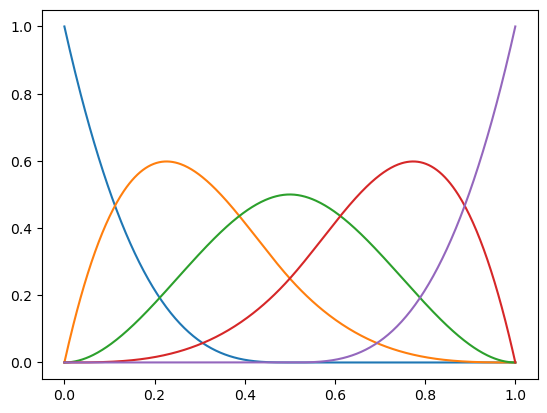

[0.26726124 0.33273756 0.3047247  0.33273756 0.26726124]


In [3]:
Bbasis = BSplineBasis(domain_range=(0, 1), n_basis=J)
Bbasis.plot()
plt.show()

G = Bbasis.gram_matrix()
norms = np.sqrt(np.diag(G))
print(norms)


So the bspline basis right now is not normalized, we times diag(1/n1,1/n2,....,1/nJ) to make it an normalized one.

$[b_1,b_2,\cdots,b_J]$ is the original bspline space.
$[\tilde{b}_1,\tilde{b}_2,\cdots,\tilde{b}_J] = diag(1/n1,1/n2,....,1/nJ) \times [b_1,b_2,\cdots,b_J]^T$ is the original bspline space.

In [4]:
bspline_norm_basis = skfda.FDataBasis(
    basis=Bbasis,
    coefficients= np.diag(1/norms)  # X_coef: coefficient on 
)
# check if times diag(1/n1,1/n2,...,1/nJ), whether the norm would be all 1.
norm_values = np.sqrt(np.sum(bspline_norm_basis.coefficients @ G * bspline_norm_basis.coefficients, axis=1))

print(norm_values)

[1. 1. 1. 1. 1.]


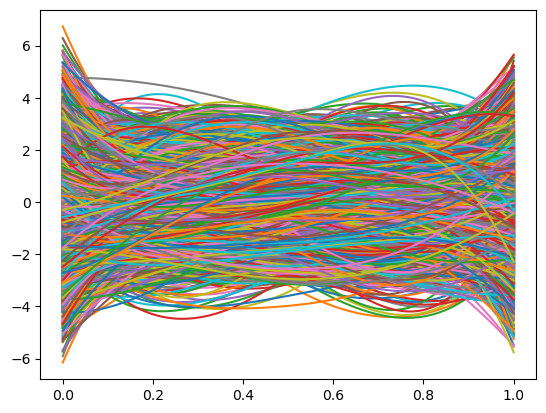

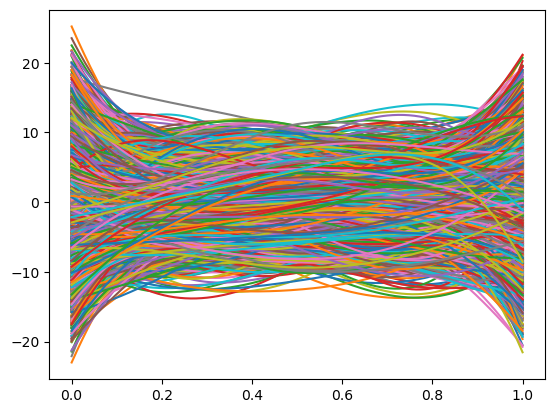

In [5]:
fd_basis1 = skfda.FDataBasis(
    basis=Bbasis,
    coefficients= X_coef   
)
fd_basis1.plot()
plt.show()

fd_basis2 = skfda.FDataBasis(
    basis=Bbasis,
    coefficients= X_coef@ np.diag(1/norms)
)
fd_basis2.plot()
plt.show()

In [6]:
fpca = FPCA(n_components=5)
fpca.fit(fd_basis1)
scores = fpca.transform(fd_basis1)

fpca_tilde = FPCA(n_components=5)
fpca_tilde.fit(fd_basis2)
scores_tilde = fpca_tilde.transform(fd_basis2)
# Explained variance ratio
print("Explained variance by each PC:", fpca.explained_variance_ratio_)
print(sum(fpca.explained_variance_ratio_))
print("Explained variance by each PC:", fpca_tilde.explained_variance_ratio_)
print(sum(fpca_tilde.explained_variance_ratio_))

Explained variance by each PC: [0.49711837 0.26527726 0.14403746 0.07724085 0.01632606]
0.9999999999999999
Explained variance by each PC: [0.45680221 0.2729644  0.17578605 0.07933374 0.0151136 ]
1.0


In [7]:
E_coef = fpca_tilde.components_.coefficients 
E_coef_tilde2 = fpca.components_.coefficients 

In [8]:
scores.shape

(10000, 5)

In [9]:
# Compute the integral of each basis function over [0,1]
def basis_integral(j):
    """Compute the integral of the j-th basis function over [0,1]."""
    return quad(lambda s: Bbasis(s)[j], 0, 1)[0]

I_j = np.array([basis_integral(j) for j in range(J)])

# Define beta coefficients (random or fixed values)
beta = np.random.randn(J)

# Compute Y
noise = np.random.normal(0, 1, size=d)
Y_np = np.sum(X_coef * beta * I_j, axis=1) + noise

In [10]:
Y_np.shape

(10000,)

In [11]:
X = torch.tensor(scores.T, dtype=torch.float32) 
print(X.size())
Y = torch.tensor(Y_np, dtype=torch.float32).view(1, d)
print(Y.size())

torch.Size([5, 10000])
torch.Size([1, 10000])


# Model adding covariates

In [12]:
trunc_q = d-1
m = d**(1/3)
print(m)
q = 4

21.544346900318832


/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/torch/_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)
/Users/xinyiwang/Desktop/UCDavis/research_alex/long-run-covariance/codes/models.py:199: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov_matrix[i, j] = torch.tensor(torch.sum(weighted_cross_cov), dtype=X.dtype, device=X.device)
/Users/xinyiwang/Desktop/UCDavis/research_alex/long-run-covariance/codes/models.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov_matrix_w1[i, j] = torch.tensor(to

Epoch [200/10000], Loss: 1.6005
Epoch [400/10000], Loss: 1.6004
Epoch [600/10000], Loss: 1.6003
Early stopping at Epoch [725/10000] - No improvement for 700 epochs.

Restoring best model and weight network...


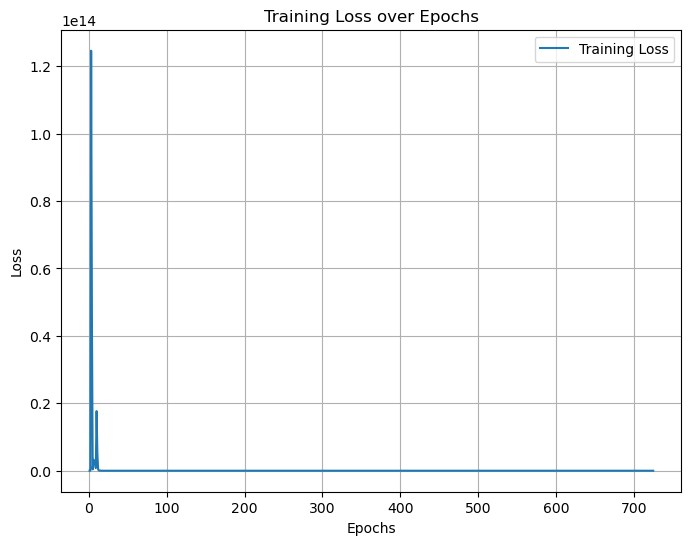

In [ ]:
trained_model, trained_weight_net = train_model(X, Y, WeightNetwork, Model1_MHA, LR_cov_X, m, q, trunc_q)

/Users/xinyiwang/Desktop/UCDavis/research_alex/long-run-covariance/codes/models.py:199: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov_matrix[i, j] = torch.tensor(torch.sum(weighted_cross_cov), dtype=X.dtype, device=X.device)
/Users/xinyiwang/Desktop/UCDavis/research_alex/long-run-covariance/codes/models.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov_matrix_w1[i, j] = torch.tensor(torch.sum(cross_cov_truncated), dtype=X.dtype, device=X.device)



Shape of Covariance Matrix (NumPy): (5, 5)


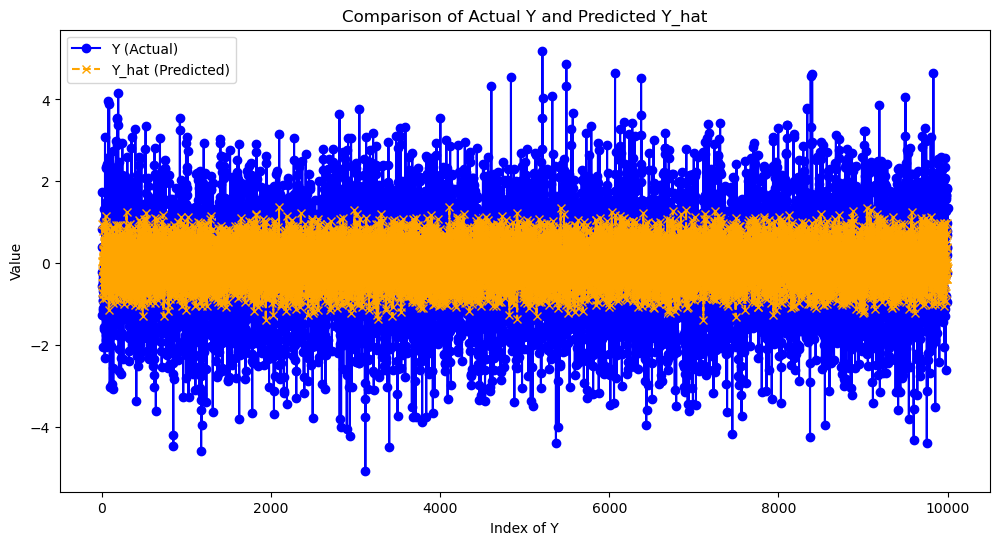

In [24]:
# Compute the best covariance matrix and predictions using the best model
with torch.no_grad():
    cov_matrix, cov_matrix_w1, cov_matrix3 = LR_cov_X(X, trained_weight_net, trunc_q)
    cov_matrix_np = cov_matrix.cpu().numpy()  # Convert to NumPy

    # Print shape of the covariance matrix
    print("\nShape of Covariance Matrix (NumPy):", cov_matrix_np.shape)

    Y_hat = trained_model(X).view(-1).detach()  # Ensure Y_hat is flattened to match (d,)
    Y_actual = Y.view(-1).detach()  # Flatten Y to (d,)

# Plotting Y and Y_hat
plt.figure(figsize=(12, 6))
plt.plot(range(len(Y_actual)), Y_actual.cpu(), label='Y (Actual)', marker='o', linestyle='-', color='blue')
plt.plot(range(len(Y_hat)), Y_hat.cpu(), label='Y_hat (Predicted)', marker='x', linestyle='--', color='orange')

plt.xlabel("Index of Y")
plt.ylabel("Value")
plt.title("Comparison of Actual Y and Predicted Y_hat")
plt.legend()
plt.show()



In [ ]:
import os
import pandas as pd
# Ensure the results directory exists
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

csv_path = os.path.join(results_dir, f"cov_matrix_case1_FMA_{d}_MHA.csv")

# Convert matrices to DataFrames
df1 = pd.DataFrame(cov_matrix)
df2 = pd.DataFrame(cov_matrix_w1)
df3 = pd.DataFrame(cov_matrix3)

# Save matrices to CSV with an empty line between them
with open(csv_path, 'w', newline='') as f:
    df1.to_csv(f, index=False, header=False)
    f.write("\n")  # Write an empty line
    df2.to_csv(f, index=False, header=False)
    f.write("\n")  # Write another empty line
    df3.to_csv(f, index=False, header=False)

print(f"Saved matrices to {csv_path} with empty lines between them.")

# Compute true covariance matrix

In [25]:
theoretical_cov_true = np.diag([3.24] * 5)

print(theoretical_cov_true)

[[3.24 0.   0.   0.   0.  ]
 [0.   3.24 0.   0.   0.  ]
 [0.   0.   3.24 0.   0.  ]
 [0.   0.   0.   3.24 0.  ]
 [0.   0.   0.   0.   3.24]]


In [26]:
coefsE_on_btilde = E_coef_tilde2@ np.diag(norms)

In [27]:
G_tilde = np.diag(1/norms) @ G @ np.diag(1/norms)

In [28]:
hat_C = np.zeros((5, 5))

for l in range(5):
    for lp in range(5):
        sum1 = np.sum([coefsE_on_btilde[l, k] * G_tilde[:, k] for k in range(5)], axis=0)
        sum2 = np.sum([coefsE_on_btilde[lp, k] * G_tilde[:, k] for k in range(5)], axis=0)
        hat_C[l, lp] = np.sum([theoretical_cov_true[i, j] * sum1[i] * sum2[j] for i in range(5) for j in range(5)])
#print(np.round(hat_C,4))

In [29]:
np.trace(hat_C)

np.float64(16.200000000000006)

In [30]:
print(np.linalg.eigvals(hat_C))
sum(np.linalg.eigvals(hat_C))

[7.36592291 4.47792876 2.83844442 0.24724557 1.27045834]


np.float64(16.200000000000014)

In [31]:
np.round(hat_C,4)

array([[ 7.3401, -0.0297,  0.3216,  0.06  , -0.1055],
       [-0.0297,  4.3778,  0.0091, -0.5587, -0.0074],
       [ 0.3216,  0.0091,  2.8546,  0.1003, -0.0551],
       [ 0.06  , -0.5587,  0.1003,  1.3776, -0.013 ],
       [-0.1055, -0.0074, -0.0551, -0.013 ,  0.2499]])

In [32]:
cov_matrix

tensor([[ 5.2438e+00,  2.6019e-01,  1.4342e-01,  5.2624e-02, -9.4405e-02],
        [ 2.5524e-02,  2.8581e+00, -1.0153e-01,  8.9288e-02,  1.9057e-02],
        [ 2.3270e-02, -1.6036e-01,  1.7288e+00, -1.1470e-01, -2.7999e-02],
        [ 2.7709e-02, -1.2613e-01, -4.0669e-02,  9.2786e-01,  7.1970e-03],
        [-5.1439e-02, -3.3116e-02,  2.1682e-04,  2.1453e-02,  1.7972e-01]])

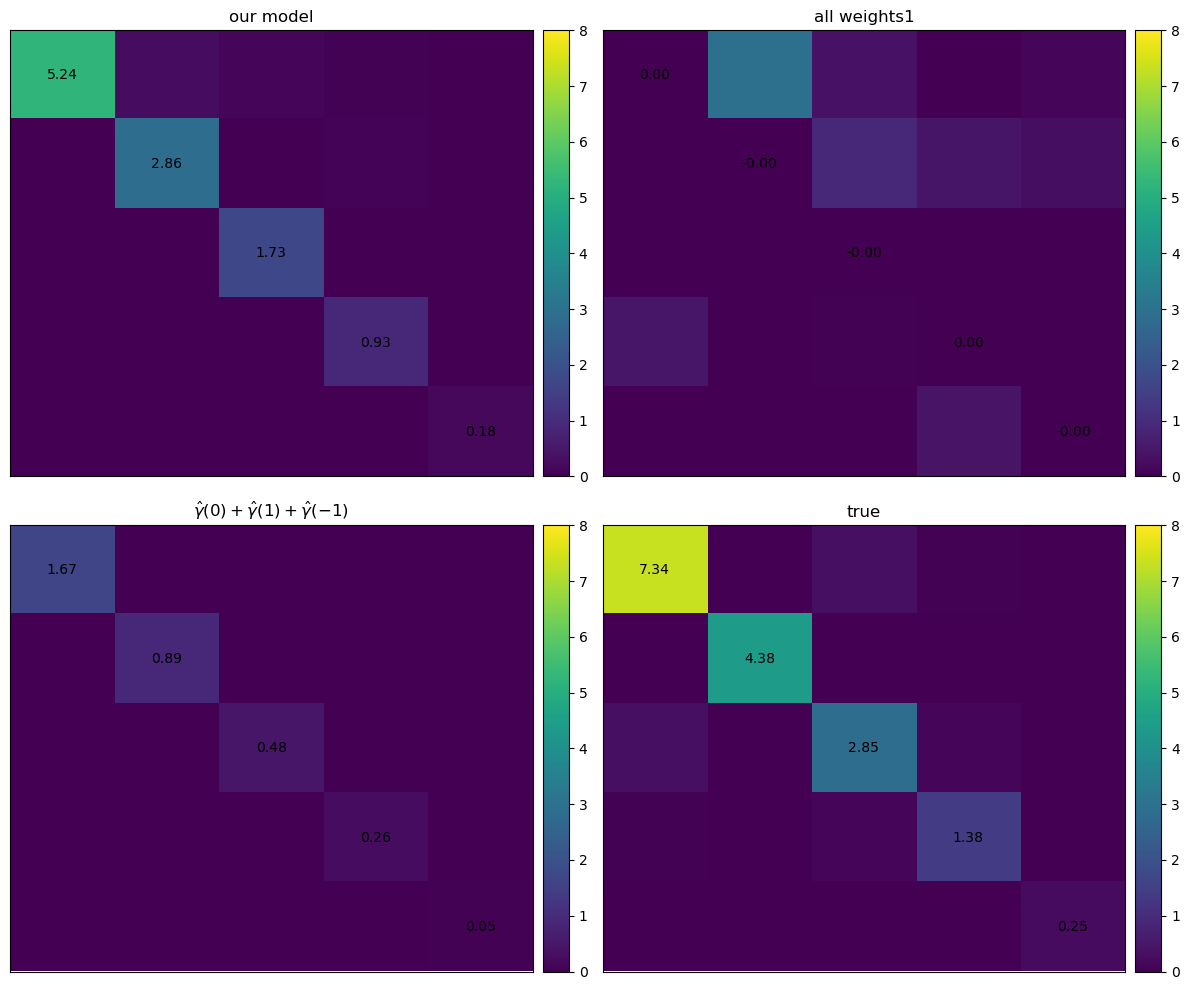

In [33]:
fig = plot_matrices_2d([cov_matrix,cov_matrix_w1, cov_matrix3, hat_C], titles = ["our model", "all weights1", r"$\hat{\gamma}(0) + \hat{\gamma}(1) + \hat{\gamma}(-1)$", "true"])

In [34]:
filename = f"figures/matrix3d_compare{d}_truc{trunc_q}_bd{round(m)}_MHA.png"
fig.savefig(filename, dpi=300, bbox_inches='tight')
plt.close(fig)  # Close the figure to free memory

print(f"Plot saved as {filename}")

Plot saved as figures/matrix3d_compare10000_truc9999_bd22_MHA.png


In [ ]:
print(range(5))

In [ ]:
print("Sum of diagonal (cov_matrix):", torch.trace(cov_matrix))
print("Sum of diagonal (cov_matrix_w1):", torch.trace(cov_matrix_w1))
print("Sum of diagonal (cov_matrix3):", torch.trace(cov_matrix3))
print("Sum of diagonal (hat_C):", np.trace(hat_C))

In [ ]:
gamma_list = np.zeros(5)
for i in range(5):
    score_i = scores[:,i]
    cross_cov = ccovf(score_i, score_i, adjusted=False, demean=True, fft=True)
    print(f"for i = {i}, gamma(0) = {cross_cov[0]}, gamma(1) = {cross_cov[1]}")
    gamma_list[i] = sum(cross_cov)

In [ ]:
gamma_list